In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *
from encoding_information.plot_utils import *

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-10-25 20:29:36.068236: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 20:29:37.792988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM


In [2]:
# load images, extract patches, and compute cov mats
edge_crop = 32
num_images = 10000
num_patches = 10000
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]


In [6]:
patch_sizes = [1, 2, 3, 5, 10, 20, 35, 50]

# load train and test patches corresponding to the biggest patch size
patches = extract_patches(images, patch_sizes[-1], num_patches=num_patches, seed=0, verbose=True)
test_patches = extract_patches(test_images, patch_sizes[-1], num_patches=num_test_images, seed=0, verbose=True)

stationary_gp_models = {}
pixel_cnn_models = {}
test_set_NLL_gp = {}
test_set_NLL_pixel_cnn = {}
mi_estimates_gp = {}
mi_estimates_pixel_cnn = {}
for patch_size in tqdm(patch_sizes):
    # take a random sub crop from the patchs
    subpatches = extract_patches(patches, patch_size, num_patches=num_patches, seed=0, verbose=False)
    test_subpatches = extract_patches(test_patches, patch_size, num_patches=num_test_images, seed=0, verbose=False)


    mi_estimates_gp[patch_size], stationary_gp_models[patch_size] = estimate_mutual_information(
        subpatches, eigenvalue_floor=eigenvalue_floor, use_iterative_optimization=True, return_entropy_model=True,
        verbose=True)
    test_set_NLL_gp[patch_size] = stationary_gp_models[patch_size].compute_negative_log_likelihood(test_subpatches)

    mi_estimates_pixel_cnn[patch_size], pixel_cnn_models[patch_size] = estimate_mutual_information(
        subpatches, entropy_model='pixelcnn', return_entropy_model=True, verbose=True)
    test_set_NLL_pixel_cnn[patch_size] = pixel_cnn_models[patch_size].compute_negative_log_likelihood(test_subpatches)


100%|██████████| 1000/1000 [00:27<00:00, 36.46it/s]
Computing loss: 9it [00:01,  5.41it/s]


Initial validation NLL: 6.21


Epoch 1: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]
Computing loss: 9it [00:00, 117.42it/s]


Epoch 1: validation NLL: 6.25


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 120.75it/s]
Computing loss: 9it [00:00, 101.03it/s]


Epoch 2: validation NLL: 6.22


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 201.64it/s]
Computing loss: 9it [00:00, 151.30it/s]


Epoch 3: validation NLL: 6.23


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 119.54it/s]
Computing loss: 9it [00:00, 128.84it/s]


Epoch 4: validation NLL: 6.24


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 132.51it/s]
Computing loss: 9it [00:00, 112.61it/s]


Epoch 5: validation NLL: 6.22


precomputing masks and variances: 100%|██████████| 1/1 [00:00<00:00, 510.50it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 1/1 [00:00<00:00, 332.06it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 6.303 differential entropy/pixel
Estimated I(Y;X) = 2.792 bits/pixel


precomputing masks and variances: 100%|██████████| 1/1 [00:00<00:00, 132.19it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 1/1 [00:00<00:00, 167.74it/s]
Computing loss: 16it [00:09,  1.71it/s]


Initial validation NLL: 135.67


Epoch 1: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]
Computing loss: 16it [00:00, 24.72it/s]


Epoch 1: validation NLL: 6.31


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 31.88it/s]
Computing loss: 16it [00:00, 57.39it/s]


Epoch 2: validation NLL: 6.32


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 30.66it/s]
Computing loss: 16it [00:00, 57.68it/s]


Epoch 3: validation NLL: 6.31


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 30.37it/s]
Computing loss: 16it [00:00, 33.44it/s]


Epoch 4: validation NLL: 6.32


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 33.32it/s]
Computing loss: 16it [00:00, 77.16it/s]


Epoch 5: validation NLL: 6.31


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 31.88it/s]
Computing loss: 16it [00:00, 46.28it/s]


Epoch 6: validation NLL: 6.31


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 37.58it/s]
Computing loss: 16it [00:00, 29.53it/s]


Epoch 7: validation NLL: 6.31


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 36.76it/s]
Computing loss: 16it [00:00, 29.45it/s]


Epoch 8: validation NLL: 6.31


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 33.25it/s]
Computing loss: 16it [00:00, 63.08it/s]


Epoch 9: validation NLL: 6.32


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 31.00it/s]
Computing loss: 16it [00:00, 25.22it/s]


Epoch 10: validation NLL: 6.32


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 30.98it/s]
Computing loss: 16it [00:00, 57.14it/s]


Epoch 11: validation NLL: 6.31


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 34.98it/s]
Computing loss: 16it [00:00, 81.40it/s]


Epoch 12: validation NLL: 6.32


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 32.10it/s]
Computing loss: 16it [00:00, 27.85it/s]


Epoch 13: validation NLL: 6.32


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 34.36it/s]
Computing loss: 16it [00:00, 71.18it/s]


Epoch 14: validation NLL: 6.31


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 34.19it/s]
Computing loss: 16it [00:00, 78.70it/s]


Epoch 15: validation NLL: 6.31


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 31.90it/s]
Computing loss: 16it [00:00, 31.41it/s]


Epoch 16: validation NLL: 6.32


Computing loss: 100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 6.305 differential entropy/pixel
Estimated I(Y;X) = 2.795 bits/pixel


Computing loss: 100%|██████████| 32/32 [00:00<00:00, 38.23it/s]
Computing loss: 9it [00:02,  3.76it/s].39s/it]


Initial validation NLL: 5.29


Epoch 1: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]
Computing loss: 9it [00:00, 65.06it/s]


Epoch 1: validation NLL: 5.29


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 51.05it/s]
Computing loss: 9it [00:00, 96.79it/s]


Epoch 2: validation NLL: 5.32


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 129.27it/s]
Computing loss: 9it [00:00, 92.29it/s]


Epoch 3: validation NLL: 5.29


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 146.87it/s]
Computing loss: 9it [00:00, 97.80it/s]


Epoch 4: validation NLL: 5.33


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 56.43it/s]
Computing loss: 9it [00:00, 106.35it/s]


Epoch 5: validation NLL: 5.31


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 154.71it/s]
Computing loss: 9it [00:00, 99.00it/s]


Epoch 6: validation NLL: 5.29


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 137.17it/s]
Computing loss: 9it [00:00, 22.73it/s]


Epoch 7: validation NLL: 5.31


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 138.94it/s]
Computing loss: 9it [00:00, 69.27it/s]


Epoch 8: validation NLL: 5.30


precomputing masks and variances: 100%|██████████| 2/2 [00:00<00:00, 134.84it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 2/2 [00:00<00:00, 90.98it/s]


Estimated H(Y|X) = 4.366 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.367 differential entropy/pixel
Estimated I(Y;X) = 1.445 bits/pixel


precomputing masks and variances: 100%|██████████| 2/2 [00:00<00:00, 327.87it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 2/2 [00:00<00:00, 374.84it/s]
Computing loss: 16it [00:11,  1.39it/s]


Initial validation NLL: 129.95


Epoch 1: 100%|██████████| 100/100 [00:23<00:00,  4.25it/s]
Computing loss: 16it [00:00, 66.30it/s]


Epoch 1: validation NLL: 6.26


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.27it/s]
Computing loss: 16it [00:00, 67.21it/s]


Epoch 2: validation NLL: 6.23


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.97it/s]
Computing loss: 16it [00:00, 68.60it/s]


Epoch 3: validation NLL: 6.06


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 26.19it/s]
Computing loss: 16it [00:00, 59.54it/s]


Epoch 4: validation NLL: 5.97


Epoch 5: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]
Computing loss: 16it [00:00, 73.49it/s]


Epoch 5: validation NLL: 6.11


Epoch 6: 100%|██████████| 100/100 [00:04<00:00, 22.43it/s]
Computing loss: 16it [00:00, 98.79it/s]


Epoch 6: validation NLL: 5.95


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 29.57it/s]
Computing loss: 16it [00:00, 55.92it/s]


Epoch 7: validation NLL: 5.95


Epoch 8: 100%|██████████| 100/100 [00:04<00:00, 24.12it/s]
Computing loss: 16it [00:00, 82.20it/s]


Epoch 8: validation NLL: 5.95


Epoch 9: 100%|██████████| 100/100 [00:04<00:00, 23.32it/s]
Computing loss: 16it [00:00, 70.70it/s]


Epoch 9: validation NLL: 5.95


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]
Computing loss: 16it [00:00, 73.48it/s]


Epoch 10: validation NLL: 5.95


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 25.23it/s]
Computing loss: 16it [00:00, 106.84it/s]


Epoch 11: validation NLL: 5.95


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]
Computing loss: 16it [00:00, 103.35it/s]


Epoch 12: validation NLL: 5.95


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 26.52it/s]
Computing loss: 16it [00:00, 78.21it/s]


Epoch 13: validation NLL: 5.95


Epoch 14: 100%|██████████| 100/100 [00:04<00:00, 24.00it/s]
Computing loss: 16it [00:00, 81.52it/s]


Epoch 14: validation NLL: 5.95


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 22.02it/s]
Computing loss: 16it [00:00, 80.36it/s]


Epoch 15: validation NLL: 5.95


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]
Computing loss: 16it [00:00, 81.70it/s]


Epoch 16: validation NLL: 5.95


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 22.80it/s]
Computing loss: 16it [00:00, 95.70it/s]


Epoch 17: validation NLL: 5.97


Computing loss: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


Estimated H(Y|X) = 4.366 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.953 differential entropy/pixel
Estimated I(Y;X) = 2.290 bits/pixel


Computing loss: 100%|██████████| 32/32 [00:00<00:00, 55.49it/s]
Computing loss: 9it [00:02,  4.32it/s].21s/it]


Initial validation NLL: 5.00


Epoch 1: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]
Computing loss: 9it [00:00, 32.28it/s]


Epoch 1: validation NLL: 5.00


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 66.70it/s]
Computing loss: 9it [00:00, 70.66it/s]


Epoch 2: validation NLL: 4.98


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 120.07it/s]
Computing loss: 9it [00:00, 77.07it/s]


Epoch 3: validation NLL: 5.00


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 65.87it/s]
Computing loss: 9it [00:00, 104.27it/s]


Epoch 4: validation NLL: 5.00


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 53.91it/s]
Computing loss: 9it [00:00, 65.37it/s]


Epoch 5: validation NLL: 4.98


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 76.86it/s]
Computing loss: 9it [00:00, 40.76it/s]


Epoch 6: validation NLL: 5.00


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 116.14it/s]
Computing loss: 9it [00:00, 68.13it/s]


Epoch 7: validation NLL: 5.02


precomputing masks and variances: 100%|██████████| 3/3 [00:00<00:00, 194.98it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 3/3 [00:00<00:00, 164.69it/s]


Estimated H(Y|X) = 4.366 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.017 differential entropy/pixel
Estimated I(Y;X) = 0.940 bits/pixel


precomputing masks and variances: 100%|██████████| 3/3 [00:00<00:00, 175.41it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 3/3 [00:00<00:00, 141.92it/s]
Computing loss: 16it [00:16,  1.04s/it]


Initial validation NLL: 124.46


Epoch 1: 100%|██████████| 100/100 [00:26<00:00,  3.75it/s]
Computing loss: 16it [00:00, 68.19it/s]


Epoch 1: validation NLL: 5.99


Epoch 2: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]
Computing loss: 16it [00:00, 50.12it/s]


Epoch 2: validation NLL: 5.91


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.87it/s]
Computing loss: 16it [00:00, 65.08it/s]


Epoch 3: validation NLL: 5.44


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 31.80it/s]
Computing loss: 16it [00:00, 64.01it/s]


Epoch 4: validation NLL: 5.21


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]
Computing loss: 16it [00:00, 28.12it/s]


Epoch 5: validation NLL: 5.11


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 30.22it/s]
Computing loss: 16it [00:00, 87.44it/s]


Epoch 6: validation NLL: 5.07


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.99it/s]
Computing loss: 16it [00:00, 68.05it/s]


Epoch 7: validation NLL: 5.04


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 30.84it/s]
Computing loss: 16it [00:00, 35.45it/s]


Epoch 8: validation NLL: 5.02


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.74it/s]
Computing loss: 16it [00:00, 28.88it/s]


Epoch 9: validation NLL: 5.04


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 29.84it/s]
Computing loss: 16it [00:00, 87.20it/s]


Epoch 10: validation NLL: 5.05


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 31.63it/s]
Computing loss: 16it [00:00, 31.14it/s]


Epoch 11: validation NLL: 5.02


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 30.45it/s]
Computing loss: 16it [00:00, 79.66it/s]


Epoch 12: validation NLL: 5.02


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 34.32it/s]
Computing loss: 16it [00:00, 76.88it/s]


Epoch 13: validation NLL: 5.06


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.95it/s]
Computing loss: 16it [00:00, 36.04it/s]


Epoch 14: validation NLL: 5.02


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]
Computing loss: 16it [00:00, 29.68it/s]


Epoch 15: validation NLL: 5.03


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 28.88it/s]
Computing loss: 16it [00:00, 23.29it/s]


Epoch 16: validation NLL: 5.02


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]
Computing loss: 16it [00:00, 24.98it/s]


Epoch 17: validation NLL: 5.01


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.31it/s]
Computing loss: 16it [00:00, 29.45it/s]


Epoch 18: validation NLL: 5.01


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 30.67it/s]
Computing loss: 16it [00:00, 79.24it/s]


Epoch 19: validation NLL: 5.03


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 25.31it/s]
Computing loss: 16it [00:00, 76.43it/s]


Epoch 20: validation NLL: 5.03


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 25.84it/s]
Computing loss: 16it [00:00, 62.04it/s]


Epoch 21: validation NLL: 5.03


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 23.59it/s]
Computing loss: 16it [00:00, 52.24it/s]


Epoch 22: validation NLL: 5.04


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]
Computing loss: 16it [00:00, 81.35it/s]


Epoch 23: validation NLL: 5.02


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 30.20it/s]
Computing loss: 16it [00:00, 83.70it/s]


Epoch 24: validation NLL: 5.02


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 26.40it/s]
Computing loss: 16it [00:00, 86.23it/s]


Epoch 25: validation NLL: 5.10


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 33.62it/s]
Computing loss: 16it [00:00, 17.73it/s]


Epoch 26: validation NLL: 5.04


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 34.23it/s]
Computing loss: 16it [00:00, 87.64it/s]


Epoch 27: validation NLL: 5.08


Epoch 28: 100%|██████████| 100/100 [00:02<00:00, 34.55it/s]
Computing loss: 16it [00:00, 64.45it/s]


Epoch 28: validation NLL: 5.03


2023-10-25 10:12:30.693179: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-25 10:12:30.693236: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[32,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f64[32,64,3,3]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-25 10:12:35.523153: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-25 10:12:35.523204: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[31,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f64[31,64,3,3]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window=

Estimated H(Y|X) = 4.366 differential entropy/pixel
Estimated H(Y) (upper bound) = 5.030 differential entropy/pixel
Estimated I(Y;X) = 0.959 bits/pixel


Computing loss: 100%|██████████| 32/32 [00:00<00:00, 38.44it/s]
Computing loss: 9it [00:01,  5.42it/s].81s/it]


Initial validation NLL: 4.76


Epoch 1: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]
Computing loss: 9it [00:00, 101.67it/s]


Epoch 1: validation NLL: 4.77


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 70.25it/s]
Computing loss: 9it [00:00, 98.53it/s]


Epoch 2: validation NLL: 4.76


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 79.37it/s]
Computing loss: 9it [00:00, 95.96it/s]


Epoch 3: validation NLL: 4.76


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 65.64it/s]
Computing loss: 9it [00:00, 32.47it/s]


Epoch 4: validation NLL: 4.76


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 81.89it/s]
Computing loss: 9it [00:00, 115.62it/s]


Epoch 5: validation NLL: 4.77


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 79.70it/s]
Computing loss: 9it [00:00, 108.59it/s]


Epoch 6: validation NLL: 4.77


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 80.30it/s]
Computing loss: 9it [00:00, 113.20it/s]


Epoch 7: validation NLL: 4.78


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 74.70it/s]
Computing loss: 9it [00:00, 131.41it/s]


Epoch 8: validation NLL: 4.78


precomputing masks and variances: 100%|██████████| 5/5 [00:00<00:00, 138.33it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 5/5 [00:00<00:00, 151.71it/s]


Estimated H(Y|X) = 4.365 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.741 differential entropy/pixel
Estimated I(Y;X) = 0.543 bits/pixel


precomputing masks and variances: 100%|██████████| 5/5 [00:00<00:00, 61.50it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 5/5 [00:00<00:00, 71.79it/s]
Computing loss: 16it [00:13,  1.20it/s]


Initial validation NLL: 116.79


Epoch 1: 100%|██████████| 100/100 [00:21<00:00,  4.65it/s]
Computing loss: 16it [00:00, 27.02it/s]


Epoch 1: validation NLL: 5.64


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]
Computing loss: 16it [00:00, 26.47it/s]


Epoch 2: validation NLL: 5.17


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 29.27it/s]
Computing loss: 16it [00:00, 49.74it/s]


Epoch 3: validation NLL: 4.91


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 29.59it/s]
Computing loss: 16it [00:00, 79.70it/s]


Epoch 4: validation NLL: 4.81


Epoch 5: 100%|██████████| 100/100 [00:04<00:00, 23.45it/s]
Computing loss: 16it [00:00, 72.83it/s]


Epoch 5: validation NLL: 4.83


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 31.35it/s]
Computing loss: 16it [00:00, 28.29it/s]


Epoch 6: validation NLL: 4.76


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 31.71it/s]
Computing loss: 16it [00:00, 60.83it/s]


Epoch 7: validation NLL: 4.78


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 32.05it/s]
Computing loss: 16it [00:00, 32.26it/s]


Epoch 8: validation NLL: 4.82


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 31.90it/s]
Computing loss: 16it [00:00, 75.13it/s]


Epoch 9: validation NLL: 4.76


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 29.02it/s]
Computing loss: 16it [00:00, 96.76it/s]


Epoch 10: validation NLL: 4.75


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 31.12it/s]
Computing loss: 16it [00:00, 105.93it/s]


Epoch 11: validation NLL: 4.75


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]
Computing loss: 16it [00:00, 63.32it/s]


Epoch 12: validation NLL: 4.74


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 30.36it/s]
Computing loss: 16it [00:00, 38.34it/s]


Epoch 13: validation NLL: 4.74


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 31.30it/s]
Computing loss: 16it [00:00, 90.77it/s]


Epoch 14: validation NLL: 4.75


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.36it/s]
Computing loss: 16it [00:00, 73.54it/s]


Epoch 15: validation NLL: 4.79


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 32.59it/s]
Computing loss: 16it [00:00, 32.58it/s]


Epoch 16: validation NLL: 4.74


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 32.47it/s]
Computing loss: 16it [00:00, 85.61it/s]


Epoch 17: validation NLL: 4.74


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 31.77it/s]
Computing loss: 16it [00:00, 84.21it/s]


Epoch 18: validation NLL: 4.75


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 32.91it/s]
Computing loss: 16it [00:00, 36.69it/s]


Epoch 19: validation NLL: 4.77


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 33.13it/s]
Computing loss: 16it [00:00, 72.36it/s]


Epoch 20: validation NLL: 4.78


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]
Computing loss: 16it [00:00, 58.58it/s]


Epoch 21: validation NLL: 4.75


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 24.21it/s]
Computing loss: 16it [00:00, 67.39it/s]


Epoch 22: validation NLL: 4.75


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]
Computing loss: 16it [00:00, 55.69it/s]


Epoch 23: validation NLL: 4.75


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.47it/s]
Computing loss: 16it [00:00, 29.41it/s]


Epoch 24: validation NLL: 4.77


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]
Computing loss: 16it [00:00, 59.73it/s]


Epoch 25: validation NLL: 4.74


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 26.76it/s]
Computing loss: 16it [00:00, 62.38it/s]


Epoch 26: validation NLL: 4.77


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 37.54it/s]
Computing loss: 16it [00:00, 95.93it/s]


Epoch 27: validation NLL: 4.80


2023-10-25 10:20:11.889026: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-25 10:20:11.889274: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[32,128,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f64[32,64,5,5]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-25 10:20:17.219104: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-25 10:20:17.219332: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[31,128,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f64[31,64,5,5]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window=

Estimated H(Y|X) = 4.365 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.745 differential entropy/pixel
Estimated I(Y;X) = 0.548 bits/pixel


Computing loss: 100%|██████████| 32/32 [00:00<00:00, 32.27it/s]
Computing loss: 9it [00:01,  5.51it/s].30s/it]


Initial validation NLL: 4.55


Epoch 1: 100%|██████████| 1/1 [00:05<00:00,  5.87s/it]
Computing loss: 9it [00:00, 80.05it/s]


Epoch 1: validation NLL: 4.55


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 40.73it/s]
Computing loss: 9it [00:00, 83.49it/s]


Epoch 2: validation NLL: 4.57


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 42.38it/s]
Computing loss: 9it [00:00, 79.03it/s]


Epoch 3: validation NLL: 4.56


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.21it/s]
Computing loss: 9it [00:00, 78.52it/s]


Epoch 4: validation NLL: 4.55


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
Computing loss: 9it [00:00, 79.38it/s]


Epoch 5: validation NLL: 4.56


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 41.04it/s]
Computing loss: 9it [00:00, 78.62it/s]


Epoch 6: validation NLL: 4.56


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 88.39it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 67.26it/s]


Estimated H(Y|X) = 4.369 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.554 differential entropy/pixel
Estimated I(Y;X) = 0.267 bits/pixel


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 80.76it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 54.78it/s]
Computing loss: 16it [00:09,  1.75it/s]


Initial validation NLL: 121.44


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]
Computing loss: 16it [00:00, 49.86it/s]


Epoch 1: validation NLL: 5.22


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 31.01it/s]
Computing loss: 16it [00:00, 69.02it/s]


Epoch 2: validation NLL: 5.10


Epoch 3: 100%|██████████| 100/100 [00:02<00:00, 37.55it/s]
Computing loss: 16it [00:00, 62.43it/s]


Epoch 3: validation NLL: 4.79


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 29.19it/s]
Computing loss: 16it [00:00, 41.30it/s]


Epoch 4: validation NLL: 4.67


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]
Computing loss: 16it [00:00, 104.43it/s]


Epoch 5: validation NLL: 4.62


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 36.59it/s]
Computing loss: 16it [00:00, 113.55it/s]


Epoch 6: validation NLL: 4.62


Epoch 7: 100%|██████████| 100/100 [00:02<00:00, 47.81it/s]
Computing loss: 16it [00:00, 134.60it/s]


Epoch 7: validation NLL: 4.64


Epoch 8: 100%|██████████| 100/100 [00:02<00:00, 35.42it/s]
Computing loss: 16it [00:00, 85.57it/s]


Epoch 8: validation NLL: 4.70


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 37.27it/s]
Computing loss: 16it [00:00, 94.95it/s]


Epoch 9: validation NLL: 4.55


Epoch 10: 100%|██████████| 100/100 [00:02<00:00, 39.16it/s]
Computing loss: 16it [00:00, 49.85it/s]


Epoch 10: validation NLL: 4.55


Epoch 11: 100%|██████████| 100/100 [00:02<00:00, 39.62it/s]
Computing loss: 16it [00:00, 110.94it/s]


Epoch 11: validation NLL: 4.56


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 36.03it/s]
Computing loss: 16it [00:00, 105.04it/s]


Epoch 12: validation NLL: 4.55


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 36.05it/s]
Computing loss: 16it [00:00, 87.95it/s]


Epoch 13: validation NLL: 4.69


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 38.11it/s]
Computing loss: 16it [00:00, 39.68it/s]


Epoch 14: validation NLL: 4.55


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 39.32it/s]
Computing loss: 16it [00:00, 124.88it/s]


Epoch 15: validation NLL: 4.53


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 38.09it/s]
Computing loss: 16it [00:00, 107.81it/s]


Epoch 16: validation NLL: 4.55


Epoch 17: 100%|██████████| 100/100 [00:02<00:00, 42.79it/s]
Computing loss: 16it [00:00, 36.78it/s]


Epoch 17: validation NLL: 4.53


Epoch 18: 100%|██████████| 100/100 [00:02<00:00, 45.02it/s]
Computing loss: 16it [00:00, 87.29it/s]


Epoch 18: validation NLL: 4.57


Epoch 19: 100%|██████████| 100/100 [00:02<00:00, 35.83it/s]
Computing loss: 16it [00:00, 88.84it/s]


Epoch 19: validation NLL: 4.53


Epoch 20: 100%|██████████| 100/100 [00:02<00:00, 36.54it/s]
Computing loss: 16it [00:00, 34.85it/s]


Epoch 20: validation NLL: 4.53


Epoch 21: 100%|██████████| 100/100 [00:02<00:00, 44.29it/s]
Computing loss: 16it [00:00, 29.08it/s]


Epoch 21: validation NLL: 4.56


Epoch 22: 100%|██████████| 100/100 [00:02<00:00, 35.91it/s]
Computing loss: 16it [00:00, 53.64it/s]


Epoch 22: validation NLL: 4.62


Epoch 23: 100%|██████████| 100/100 [00:02<00:00, 35.21it/s]
Computing loss: 16it [00:00, 94.70it/s]


Epoch 23: validation NLL: 4.55


Epoch 24: 100%|██████████| 100/100 [00:02<00:00, 41.92it/s]
Computing loss: 16it [00:00, 37.23it/s]


Epoch 24: validation NLL: 4.53


Epoch 25: 100%|██████████| 100/100 [00:02<00:00, 42.74it/s]
Computing loss: 16it [00:00, 98.25it/s]


Epoch 25: validation NLL: 4.57


Epoch 26: 100%|██████████| 100/100 [00:02<00:00, 35.60it/s]
Computing loss: 16it [00:00, 83.88it/s]


Epoch 26: validation NLL: 4.53


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 36.07it/s]
Computing loss: 16it [00:00, 31.86it/s]


Epoch 27: validation NLL: 4.64


Epoch 28: 100%|██████████| 100/100 [00:02<00:00, 39.44it/s]
Computing loss: 16it [00:00, 38.73it/s]


Epoch 28: validation NLL: 4.53


Epoch 29: 100%|██████████| 100/100 [00:02<00:00, 45.94it/s]
Computing loss: 16it [00:00, 106.67it/s]


Epoch 29: validation NLL: 4.53


Epoch 30: 100%|██████████| 100/100 [00:02<00:00, 36.56it/s]
Computing loss: 16it [00:00, 87.38it/s]


Epoch 30: validation NLL: 4.54


2023-10-25 10:26:58.816557: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-25 10:26:58.817904: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[32,128,10,10]{3,2,1,0}, u8[0]{0}) custom-call(f64[32,64,10,10]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-25 10:27:04.035690: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-25 10:27:04.035907: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[31,128,10,10]{3,2,1,0}, u8[0]{0}) custom-call(f64[31,64,10,10]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}),

Estimated H(Y|X) = 4.369 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.525 differential entropy/pixel
Estimated I(Y;X) = 0.226 bits/pixel


Computing loss: 100%|██████████| 32/32 [00:00<00:00, 32.30it/s]
Computing loss: 9it [00:02,  3.13it/s].03s/it]


Initial validation NLL: 4.46


Epoch 1: 100%|██████████| 1/1 [00:16<00:00, 16.78s/it]
Computing loss: 9it [00:00, 12.40it/s]


Epoch 1: validation NLL: 4.46


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]
Computing loss: 9it [00:00, 23.29it/s]


Epoch 2: validation NLL: 4.47


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]
Computing loss: 9it [00:00, 13.65it/s]


Epoch 3: validation NLL: 4.46


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]
Computing loss: 9it [00:00, 13.37it/s]


Epoch 4: validation NLL: 4.47


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]
Computing loss: 9it [00:00, 20.98it/s]


Epoch 5: validation NLL: 4.47


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]
Computing loss: 9it [00:00, 17.47it/s]


Epoch 6: validation NLL: 4.46


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]
Computing loss: 9it [00:00, 13.47it/s]


Epoch 7: validation NLL: 4.47


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]
Computing loss: 9it [00:00, 20.44it/s]


Epoch 8: validation NLL: 4.46


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]
Computing loss: 9it [00:00, 24.62it/s]


Epoch 9: validation NLL: 4.47


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
Computing loss: 9it [00:00, 22.01it/s]


Epoch 10: validation NLL: 4.47


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]
Computing loss: 9it [00:00, 12.66it/s]


Epoch 11: validation NLL: 4.47


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
Computing loss: 9it [00:00, 23.24it/s]


Epoch 12: validation NLL: 4.47


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
Computing loss: 9it [00:00, 20.26it/s]


Epoch 13: validation NLL: 4.47


precomputing masks and variances: 100%|██████████| 20/20 [00:00<00:00, 33.06it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 20/20 [00:00<00:00, 31.24it/s]


Estimated H(Y|X) = 4.373 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.459 differential entropy/pixel
Estimated I(Y;X) = 0.124 bits/pixel


precomputing masks and variances: 100%|██████████| 20/20 [00:00<00:00, 28.17it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 20/20 [00:00<00:00, 32.16it/s]
Computing loss: 16it [00:20,  1.27s/it]


Initial validation NLL: 117.94


Epoch 1: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]
Computing loss: 16it [00:00, 27.18it/s]


Epoch 1: validation NLL: 5.23


Epoch 2: 100%|██████████| 100/100 [00:05<00:00, 18.80it/s]
Computing loss: 16it [00:00, 67.93it/s]


Epoch 2: validation NLL: 4.92


Epoch 3: 100%|██████████| 100/100 [00:04<00:00, 21.59it/s]
Computing loss: 16it [00:00, 31.38it/s]


Epoch 3: validation NLL: 4.60


Epoch 4: 100%|██████████| 100/100 [00:05<00:00, 18.63it/s]
Computing loss: 16it [00:00, 55.71it/s]


Epoch 4: validation NLL: 4.50


Epoch 5: 100%|██████████| 100/100 [00:05<00:00, 18.19it/s]
Computing loss: 16it [00:00, 46.88it/s]


Epoch 5: validation NLL: 4.48


Epoch 6: 100%|██████████| 100/100 [00:05<00:00, 19.42it/s]
Computing loss: 16it [00:00, 27.27it/s]


Epoch 6: validation NLL: 4.45


Epoch 7: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]
Computing loss: 16it [00:00, 80.16it/s]


Epoch 7: validation NLL: 4.44


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]
Computing loss: 16it [00:00, 66.95it/s]


Epoch 8: validation NLL: 4.47


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.08it/s]
Computing loss: 16it [00:00, 80.25it/s]


Epoch 9: validation NLL: 4.44


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]
Computing loss: 16it [00:00, 28.11it/s]


Epoch 10: validation NLL: 4.47


Epoch 11: 100%|██████████| 100/100 [00:04<00:00, 23.80it/s]
Computing loss: 16it [00:00, 64.11it/s]


Epoch 11: validation NLL: 4.47


Epoch 12: 100%|██████████| 100/100 [00:04<00:00, 22.69it/s]
Computing loss: 16it [00:00, 70.99it/s]


Epoch 12: validation NLL: 4.44


Epoch 13: 100%|██████████| 100/100 [00:04<00:00, 24.21it/s]
Computing loss: 16it [00:00, 83.48it/s]


Epoch 13: validation NLL: 4.50


Epoch 14: 100%|██████████| 100/100 [00:04<00:00, 24.31it/s]
Computing loss: 16it [00:00, 29.09it/s]


Epoch 14: validation NLL: 4.43


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 24.14it/s]
Computing loss: 16it [00:00, 73.97it/s]


Epoch 15: validation NLL: 4.44


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 21.28it/s]
Computing loss: 16it [00:00, 79.87it/s]


Epoch 16: validation NLL: 4.44


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 20.95it/s]
Computing loss: 16it [00:00, 69.59it/s]


Epoch 17: validation NLL: 4.43


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 23.14it/s]
Computing loss: 16it [00:00, 28.85it/s]


Epoch 18: validation NLL: 4.41


Epoch 19: 100%|██████████| 100/100 [00:04<00:00, 23.40it/s]
Computing loss: 16it [00:00, 67.25it/s]


Epoch 19: validation NLL: 4.42


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 21.55it/s]
Computing loss: 16it [00:00, 65.82it/s]


Epoch 20: validation NLL: 4.41


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 20.48it/s]
Computing loss: 16it [00:00, 63.53it/s]


Epoch 21: validation NLL: 4.49


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 21.10it/s]
Computing loss: 16it [00:00, 72.38it/s]


Epoch 22: validation NLL: 4.43


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 21.21it/s]
Computing loss: 16it [00:00, 58.26it/s]


Epoch 23: validation NLL: 4.41


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 21.81it/s]
Computing loss: 16it [00:00, 65.18it/s]


Epoch 24: validation NLL: 4.41


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 22.83it/s]
Computing loss: 16it [00:00, 31.96it/s]


Epoch 25: validation NLL: 4.40


Epoch 26: 100%|██████████| 100/100 [00:05<00:00, 19.86it/s]
Computing loss: 16it [00:00, 57.92it/s]


Epoch 26: validation NLL: 4.42


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 22.08it/s]
Computing loss: 16it [00:00, 66.21it/s]


Epoch 27: validation NLL: 4.42


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 23.10it/s]
Computing loss: 16it [00:00, 30.12it/s]


Epoch 28: validation NLL: 4.41


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 23.46it/s]
Computing loss: 16it [00:00, 25.17it/s]


Epoch 29: validation NLL: 4.41


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 22.14it/s]
Computing loss: 16it [00:00, 63.00it/s]


Epoch 30: validation NLL: 4.42


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 21.59it/s]
Computing loss: 16it [00:00, 74.67it/s]


Epoch 31: validation NLL: 4.40


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 23.26it/s]
Computing loss: 16it [00:00, 29.07it/s]


Epoch 32: validation NLL: 4.40


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 23.20it/s]
Computing loss: 16it [00:00, 65.59it/s]


Epoch 33: validation NLL: 4.44


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 21.65it/s]
Computing loss: 16it [00:00, 57.91it/s]


Epoch 34: validation NLL: 4.40


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 21.62it/s]
Computing loss: 16it [00:00, 61.79it/s]


Epoch 35: validation NLL: 4.40


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 23.09it/s]
Computing loss: 16it [00:00, 29.90it/s]


Epoch 36: validation NLL: 4.40


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 22.31it/s]
Computing loss: 16it [00:00, 28.57it/s]


Epoch 37: validation NLL: 4.43


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 23.54it/s]
Computing loss: 16it [00:00, 59.75it/s]


Epoch 38: validation NLL: 4.40


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 21.49it/s]
Computing loss: 16it [00:00, 74.18it/s]


Epoch 39: validation NLL: 4.41


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 21.02it/s]
Computing loss: 16it [00:00, 66.43it/s]


Epoch 40: validation NLL: 4.42


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 21.69it/s]
Computing loss: 16it [00:00, 66.27it/s]


Epoch 41: validation NLL: 4.48


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 20.35it/s]
Computing loss: 16it [00:00, 75.64it/s]


Epoch 42: validation NLL: 4.40


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]
Computing loss: 16it [00:00, 73.90it/s]


Epoch 43: validation NLL: 4.42


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 24.43it/s]
Computing loss: 16it [00:00, 65.04it/s]


Epoch 44: validation NLL: 4.43


2023-10-25 10:38:07.531267: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-25 10:38:07.531937: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[32,128,20,20]{3,2,1,0}, u8[0]{0}) custom-call(f64[32,64,20,20]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-25 10:38:14.436097: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-25 10:38:14.436160: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[31,128,20,20]{3,2,1,0}, u8[0]{0}) custom-call(f64[31,64,20,20]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}),

Estimated H(Y|X) = 4.373 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.400 differential entropy/pixel
Estimated I(Y;X) = 0.039 bits/pixel


Computing loss: 100%|██████████| 32/32 [00:02<00:00, 13.88it/s]
Computing loss: 9it [00:05,  1.78it/s].87s/it]


Initial validation NLL: 418.10


Epoch 1: 100%|██████████| 1/1 [01:56<00:00, 116.79s/it]
Computing loss: 9it [00:01,  6.09it/s]


Epoch 1: validation NLL: 4.48


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
Computing loss: 9it [00:01,  5.45it/s]


Epoch 2: validation NLL: 4.46


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]
Computing loss: 9it [00:01,  5.15it/s]


Epoch 3: validation NLL: 4.45


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]
Computing loss: 9it [00:01,  5.02it/s]


Epoch 4: validation NLL: 4.45


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
Computing loss: 9it [00:01,  5.56it/s]


Epoch 5: validation NLL: 4.44


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
Computing loss: 9it [00:01,  6.36it/s]


Epoch 6: validation NLL: 4.45


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
Computing loss: 9it [00:01,  5.70it/s]


Epoch 7: validation NLL: 4.44


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]
Computing loss: 9it [00:01,  4.85it/s]


Epoch 8: validation NLL: 4.44


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]
Computing loss: 9it [00:01,  5.24it/s]


Epoch 9: validation NLL: 4.44


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]
Computing loss: 9it [00:01,  5.76it/s]


Epoch 10: validation NLL: 4.45


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]
Computing loss: 9it [00:01,  5.03it/s]


Epoch 11: validation NLL: 4.44


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]
Computing loss: 9it [00:01,  5.55it/s]


Epoch 12: validation NLL: 4.44


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]
Computing loss: 9it [00:01,  5.53it/s]


Epoch 13: validation NLL: 4.44


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]
Computing loss: 9it [00:01,  5.93it/s]


Epoch 14: validation NLL: 4.44


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
Computing loss: 9it [00:01,  5.04it/s]


Epoch 15: validation NLL: 4.44


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]
Computing loss: 9it [00:01,  4.82it/s]


Epoch 16: validation NLL: 4.44


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]
Computing loss: 9it [00:01,  5.67it/s]


Epoch 17: validation NLL: 4.44


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]
Computing loss: 9it [00:01,  5.27it/s]


Epoch 18: validation NLL: 4.44


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]
Computing loss: 9it [00:01,  4.78it/s]


Epoch 19: validation NLL: 4.44


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]
Computing loss: 9it [00:01,  5.02it/s]


Epoch 20: validation NLL: 4.44


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]
Computing loss: 9it [00:01,  5.45it/s]


Epoch 21: validation NLL: 4.44


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
Computing loss: 9it [00:01,  5.80it/s]


Epoch 22: validation NLL: 4.44


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
Computing loss: 9it [00:01,  5.11it/s]


Epoch 23: validation NLL: 4.44


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]
Computing loss: 9it [00:01,  4.97it/s]


Epoch 24: validation NLL: 4.45


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
Computing loss: 9it [00:01,  5.70it/s]


Epoch 25: validation NLL: 4.45


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]
Computing loss: 9it [00:01,  5.81it/s]


Epoch 26: validation NLL: 4.45


precomputing masks and variances: 100%|██████████| 35/35 [00:02<00:00, 12.64it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 35/35 [00:01<00:00, 23.81it/s]


Estimated H(Y|X) = 4.372 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.439 differential entropy/pixel
Estimated I(Y;X) = 0.097 bits/pixel


precomputing masks and variances: 100%|██████████| 35/35 [00:01<00:00, 20.87it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 35/35 [00:01<00:00, 19.42it/s]
Computing loss: 16it [00:29,  1.83s/it]


Initial validation NLL: 113.77


Epoch 1: 100%|██████████| 100/100 [00:36<00:00,  2.72it/s]
Computing loss: 16it [00:00, 20.45it/s]


Epoch 1: validation NLL: 4.96


Epoch 2: 100%|██████████| 100/100 [00:09<00:00, 10.27it/s]
Computing loss: 16it [00:00, 31.54it/s]


Epoch 2: validation NLL: 4.73


Epoch 3: 100%|██████████| 100/100 [00:09<00:00, 10.67it/s]
Computing loss: 16it [00:00, 17.70it/s]


Epoch 3: validation NLL: 4.53


Epoch 4: 100%|██████████| 100/100 [00:09<00:00, 10.28it/s]
Computing loss: 16it [00:00, 31.30it/s]


Epoch 4: validation NLL: 4.45


Epoch 5: 100%|██████████| 100/100 [00:09<00:00, 11.10it/s]
Computing loss: 16it [00:00, 22.36it/s]


Epoch 5: validation NLL: 4.50


Epoch 6: 100%|██████████| 100/100 [00:09<00:00, 10.60it/s]
Computing loss: 16it [00:00, 21.11it/s]


Epoch 6: validation NLL: 4.42


Epoch 7: 100%|██████████| 100/100 [00:08<00:00, 11.24it/s]
Computing loss: 16it [00:00, 21.18it/s]


Epoch 7: validation NLL: 4.54


Epoch 8: 100%|██████████| 100/100 [00:08<00:00, 11.19it/s]
Computing loss: 16it [00:00, 36.23it/s]


Epoch 8: validation NLL: 4.68


Epoch 9: 100%|██████████| 100/100 [00:08<00:00, 11.30it/s]
Computing loss: 16it [00:00, 32.66it/s]


Epoch 9: validation NLL: 4.41


Epoch 10: 100%|██████████| 100/100 [00:08<00:00, 11.92it/s]
Computing loss: 16it [00:00, 25.44it/s]


Epoch 10: validation NLL: 4.40


Epoch 11: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]
Computing loss: 16it [00:00, 25.59it/s]


Epoch 11: validation NLL: 4.38


Epoch 12: 100%|██████████| 100/100 [00:08<00:00, 11.99it/s]
Computing loss: 16it [00:00, 45.92it/s]


Epoch 12: validation NLL: 4.39


Epoch 13: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]
Computing loss: 16it [00:00, 41.08it/s]


Epoch 13: validation NLL: 4.37


Epoch 14: 100%|██████████| 100/100 [00:08<00:00, 12.06it/s]
Computing loss: 16it [00:00, 21.02it/s]


Epoch 14: validation NLL: 4.43


Epoch 15: 100%|██████████| 100/100 [00:08<00:00, 11.27it/s]
Computing loss: 16it [00:00, 41.62it/s]


Epoch 15: validation NLL: 4.37


Epoch 16: 100%|██████████| 100/100 [00:09<00:00, 10.76it/s]
Computing loss: 16it [00:00, 44.41it/s]


Epoch 16: validation NLL: 4.37


Epoch 17: 100%|██████████| 100/100 [00:08<00:00, 11.14it/s]
Computing loss: 16it [00:00, 25.32it/s]


Epoch 17: validation NLL: 4.46


Epoch 18: 100%|██████████| 100/100 [00:08<00:00, 11.27it/s]
Computing loss: 16it [00:00, 23.51it/s]


Epoch 18: validation NLL: 4.36


Epoch 19: 100%|██████████| 100/100 [00:08<00:00, 11.12it/s]
Computing loss: 16it [00:00, 27.93it/s]


Epoch 19: validation NLL: 4.37


Epoch 20: 100%|██████████| 100/100 [00:09<00:00, 10.88it/s]
Computing loss: 16it [00:00, 35.98it/s]


Epoch 20: validation NLL: 4.36


Epoch 21: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]
Computing loss: 16it [00:00, 23.88it/s]


Epoch 21: validation NLL: 4.36


Epoch 22: 100%|██████████| 100/100 [00:09<00:00, 11.04it/s]
Computing loss: 16it [00:00, 35.27it/s]


Epoch 22: validation NLL: 4.36


Epoch 23: 100%|██████████| 100/100 [00:09<00:00, 10.79it/s]
Computing loss: 16it [00:00, 35.80it/s]


Epoch 23: validation NLL: 4.36


Epoch 24: 100%|██████████| 100/100 [00:08<00:00, 11.11it/s]
Computing loss: 16it [00:00, 28.02it/s]


Epoch 24: validation NLL: 4.36


Epoch 25: 100%|██████████| 100/100 [00:09<00:00, 10.87it/s]
Computing loss: 16it [00:00, 31.96it/s]


Epoch 25: validation NLL: 4.51


Epoch 26: 100%|██████████| 100/100 [00:08<00:00, 11.28it/s]
Computing loss: 16it [00:00, 27.96it/s]


Epoch 26: validation NLL: 4.35


Epoch 27: 100%|██████████| 100/100 [00:07<00:00, 12.69it/s]
Computing loss: 16it [00:00, 39.27it/s]


Epoch 27: validation NLL: 4.36


Epoch 28: 100%|██████████| 100/100 [00:07<00:00, 12.53it/s]
Computing loss: 16it [00:00, 42.40it/s]


Epoch 28: validation NLL: 4.35


Epoch 29: 100%|██████████| 100/100 [00:07<00:00, 13.13it/s]
Computing loss: 16it [00:00, 40.63it/s]


Epoch 29: validation NLL: 4.38


Epoch 30: 100%|██████████| 100/100 [00:07<00:00, 12.51it/s]
Computing loss: 16it [00:00, 49.76it/s]


Epoch 30: validation NLL: 4.35


Epoch 31: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]
Computing loss: 16it [00:00, 20.27it/s]


Epoch 31: validation NLL: 4.37


Epoch 32: 100%|██████████| 100/100 [00:08<00:00, 11.45it/s]
Computing loss: 16it [00:00, 23.66it/s]


Epoch 32: validation NLL: 4.37


Epoch 33: 100%|██████████| 100/100 [00:07<00:00, 12.61it/s]
Computing loss: 16it [00:00, 48.97it/s]


Epoch 33: validation NLL: 4.36


Epoch 34: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]
Computing loss: 16it [00:00, 21.11it/s]


Epoch 34: validation NLL: 4.35


Epoch 35: 100%|██████████| 100/100 [00:08<00:00, 11.92it/s]
Computing loss: 16it [00:00, 18.78it/s]


Epoch 35: validation NLL: 4.34


Epoch 36: 100%|██████████| 100/100 [00:07<00:00, 13.75it/s]
Computing loss: 16it [00:00, 44.71it/s]


Epoch 36: validation NLL: 4.41


Epoch 37: 100%|██████████| 100/100 [00:08<00:00, 12.24it/s]
Computing loss: 16it [00:00, 51.85it/s]


Epoch 37: validation NLL: 5.75


Epoch 38: 100%|██████████| 100/100 [00:07<00:00, 12.53it/s]
Computing loss: 16it [00:00, 23.86it/s]


Epoch 38: validation NLL: 5.74


Epoch 39: 100%|██████████| 100/100 [00:07<00:00, 13.21it/s]
Computing loss: 16it [00:00, 48.02it/s]


Epoch 39: validation NLL: 5.74


Epoch 40: 100%|██████████| 100/100 [00:07<00:00, 12.66it/s]
Computing loss: 16it [00:00, 48.48it/s]


Epoch 40: validation NLL: 5.74


Epoch 41: 100%|██████████| 100/100 [00:07<00:00, 13.17it/s]
Computing loss: 16it [00:00, 16.65it/s]


Epoch 41: validation NLL: 5.74


Epoch 42: 100%|██████████| 100/100 [00:07<00:00, 14.28it/s]
Computing loss: 16it [00:00, 25.73it/s]


Epoch 42: validation NLL: 5.74


Epoch 43: 100%|██████████| 100/100 [00:07<00:00, 13.62it/s]
Computing loss: 16it [00:00, 24.25it/s]


Epoch 43: validation NLL: 5.74


Epoch 44: 100%|██████████| 100/100 [00:08<00:00, 12.42it/s]
Computing loss: 16it [00:00, 18.43it/s]


Epoch 44: validation NLL: 5.74


Epoch 45: 100%|██████████| 100/100 [00:08<00:00, 12.11it/s]
Computing loss: 16it [00:00, 34.56it/s]


Epoch 45: validation NLL: 5.74


2023-10-25 10:58:15.821112: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-25 10:58:15.821303: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[32,128,35,35]{3,2,1,0}, u8[0]{0}) custom-call(f64[32,64,35,35]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-25 10:58:20.347485: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-25 10:58:20.347791: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[32,128,35,35]{3,2,1,0}, u8[0]{0}) custom-call(f64[32,128,35,35]{3,2,1,0}, f64[128,128,1,1]{3,2,1,0}, f64[128]{0}

Estimated H(Y|X) = 4.372 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.349 differential entropy/pixel
Estimated I(Y;X) = -0.033 bits/pixel


 88%|████████▊ | 7/8 [1:07:49<12:27, 747.90s/it]2023-10-25 11:06:02.612839: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_average_diagonals_to_make_doubly_toeplitz] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-10-25 11:10:25.719161: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 6m23.098041511s

********************************
[Compiling module jit_average_diagonals_to_make_doubly_toeplitz] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-10-25 11:10:29.647450: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 89000000 exceeds 10% of free system memory.
2023-10-25 11:10:29.748421: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 89000000 exc

Initial validation NLL: 5404.93


2023-10-25 11:19:20.192546: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 6m30.935068551s

********************************
[Compiling module jit__train_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch 1: 100%|██████████| 1/1 [08:45<00:00, 525.12s/it]
Computing loss: 9it [00:06,  1.32it/s]


Epoch 1: validation NLL: 459.44


Epoch 2: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]
Computing loss: 9it [00:06,  1.31it/s]


Epoch 2: validation NLL: 4.45


Epoch 3: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]
Computing loss: 9it [00:06,  1.39it/s]


Epoch 3: validation NLL: 4.43


Epoch 4: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]
Computing loss: 9it [00:06,  1.38it/s]


Epoch 4: validation NLL: 4.43


Epoch 5: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]
Computing loss: 9it [00:05,  1.62it/s]


Epoch 5: validation NLL: 4.42


Epoch 6: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it]
Computing loss: 9it [00:06,  1.37it/s]


Epoch 6: validation NLL: 4.43


Epoch 7: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]
Computing loss: 9it [00:06,  1.30it/s]


Epoch 7: validation NLL: 4.43


Epoch 8: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]
Computing loss: 9it [00:06,  1.34it/s]


Epoch 8: validation NLL: 4.43


Epoch 9: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]
Computing loss: 9it [00:05,  1.60it/s]


Epoch 9: validation NLL: 4.43


Epoch 10: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]
Computing loss: 9it [00:05,  1.55it/s]


Epoch 10: validation NLL: 4.42


precomputing masks and variances: 100%|██████████| 50/50 [00:04<00:00, 10.43it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 50/50 [00:02<00:00, 20.43it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.425 differential entropy/pixel
Estimated I(Y;X) = 0.083 bits/pixel


precomputing masks and variances: 100%|██████████| 50/50 [00:02<00:00, 20.12it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 50/50 [00:02<00:00, 18.61it/s]
2023-10-25 11:25:27.659184: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 80000000 exceeds 10% of free system memory.
2023-10-25 11:25:27.718928: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 80000000 exceeds 10% of free system memory.
Computing loss: 16it [00:30,  1.90s/it]


Initial validation NLL: 120.02


Epoch 1: 100%|██████████| 100/100 [00:44<00:00,  2.27it/s]
Computing loss: 16it [00:00, 18.34it/s]


Epoch 1: validation NLL: 5.12


Epoch 2: 100%|██████████| 100/100 [00:13<00:00,  7.57it/s]
Computing loss: 16it [00:00, 29.66it/s]


Epoch 2: validation NLL: 4.72


Epoch 3: 100%|██████████| 100/100 [00:12<00:00,  7.86it/s]
Computing loss: 16it [00:00, 19.73it/s]


Epoch 3: validation NLL: 4.77


Epoch 4: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s]
Computing loss: 16it [00:00, 20.36it/s]


Epoch 4: validation NLL: 4.46


Epoch 5: 100%|██████████| 100/100 [00:12<00:00,  8.21it/s]
Computing loss: 16it [00:00, 34.30it/s]


Epoch 5: validation NLL: 4.51


Epoch 6: 100%|██████████| 100/100 [00:12<00:00,  8.26it/s]
Computing loss: 16it [00:00, 23.52it/s]


Epoch 6: validation NLL: 4.40


Epoch 7: 100%|██████████| 100/100 [00:11<00:00,  8.49it/s]
Computing loss: 16it [00:00, 21.26it/s]


Epoch 7: validation NLL: 4.40


Epoch 8: 100%|██████████| 100/100 [00:11<00:00,  8.34it/s]
Computing loss: 16it [00:00, 33.83it/s]


Epoch 8: validation NLL: 4.59


Epoch 9: 100%|██████████| 100/100 [00:12<00:00,  8.31it/s]
Computing loss: 16it [00:00, 20.29it/s]


Epoch 9: validation NLL: 4.55


Epoch 10: 100%|██████████| 100/100 [00:11<00:00,  8.61it/s]
Computing loss: 16it [00:00, 21.92it/s]


Epoch 10: validation NLL: 4.43


Epoch 11: 100%|██████████| 100/100 [00:11<00:00,  8.44it/s]
Computing loss: 16it [00:00, 34.00it/s]


Epoch 11: validation NLL: 4.38


Epoch 12: 100%|██████████| 100/100 [00:12<00:00,  8.23it/s]
Computing loss: 16it [00:00, 20.93it/s]


Epoch 12: validation NLL: 4.39


Epoch 13: 100%|██████████| 100/100 [00:11<00:00,  8.57it/s]
Computing loss: 16it [00:00, 23.57it/s]


Epoch 13: validation NLL: 4.38


Epoch 14: 100%|██████████| 100/100 [00:12<00:00,  8.24it/s]
Computing loss: 16it [00:00, 19.51it/s]


Epoch 14: validation NLL: 4.37


Epoch 15: 100%|██████████| 100/100 [00:11<00:00,  8.52it/s]
Computing loss: 16it [00:00, 20.34it/s]


Epoch 15: validation NLL: 4.35


Epoch 16: 100%|██████████| 100/100 [00:11<00:00,  8.47it/s]
Computing loss: 16it [00:00, 20.42it/s]


Epoch 16: validation NLL: 4.36


Epoch 17: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s]
Computing loss: 16it [00:00, 20.28it/s]


Epoch 17: validation NLL: 4.35


Epoch 18: 100%|██████████| 100/100 [00:11<00:00,  8.57it/s]
Computing loss: 16it [00:00, 23.04it/s]


Epoch 18: validation NLL: 4.44


Epoch 19: 100%|██████████| 100/100 [00:11<00:00,  8.38it/s]
Computing loss: 16it [00:00, 20.17it/s]


Epoch 19: validation NLL: 4.34


Epoch 20: 100%|██████████| 100/100 [00:11<00:00,  8.59it/s]
Computing loss: 16it [00:00, 20.57it/s]


Epoch 20: validation NLL: 4.37


Epoch 21: 100%|██████████| 100/100 [00:11<00:00,  8.57it/s]
Computing loss: 16it [00:00, 22.60it/s]


Epoch 21: validation NLL: 4.35


Epoch 22: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s]
Computing loss: 16it [00:00, 33.40it/s]


Epoch 22: validation NLL: 4.34


Epoch 23: 100%|██████████| 100/100 [00:12<00:00,  8.26it/s]
Computing loss: 16it [00:00, 20.10it/s]


Epoch 23: validation NLL: 4.33


Epoch 24: 100%|██████████| 100/100 [00:11<00:00,  8.55it/s]
Computing loss: 16it [00:00, 21.39it/s]


Epoch 24: validation NLL: 4.32


Epoch 25: 100%|██████████| 100/100 [00:11<00:00,  8.38it/s]
Computing loss: 16it [00:00, 33.67it/s]


Epoch 25: validation NLL: 4.33


Epoch 26: 100%|██████████| 100/100 [00:11<00:00,  8.37it/s]
Computing loss: 16it [00:00, 20.33it/s]


Epoch 26: validation NLL: 4.33


Epoch 27: 100%|██████████| 100/100 [00:11<00:00,  8.59it/s]
Computing loss: 16it [00:00, 20.95it/s]


Epoch 27: validation NLL: 4.32


Epoch 28: 100%|██████████| 100/100 [00:11<00:00,  8.61it/s]
Computing loss: 16it [00:00, 23.04it/s]


Epoch 28: validation NLL: 4.34


Epoch 29: 100%|██████████| 100/100 [00:12<00:00,  8.26it/s]
Computing loss: 16it [00:00, 26.91it/s]


Epoch 29: validation NLL: 4.34


Epoch 30: 100%|██████████| 100/100 [00:12<00:00,  7.89it/s]
Computing loss: 16it [00:00, 33.49it/s]


Epoch 30: validation NLL: 4.35


Epoch 31: 100%|██████████| 100/100 [00:13<00:00,  7.54it/s]
Computing loss: 16it [00:00, 34.51it/s]


Epoch 31: validation NLL: 4.33


Epoch 32: 100%|██████████| 100/100 [00:12<00:00,  7.75it/s]
Computing loss: 16it [00:00, 27.84it/s]


Epoch 32: validation NLL: 4.31


Epoch 33: 100%|██████████| 100/100 [00:12<00:00,  7.77it/s]
Computing loss: 16it [00:00, 20.15it/s]


Epoch 33: validation NLL: 4.31


Epoch 34: 100%|██████████| 100/100 [00:12<00:00,  7.71it/s]
Computing loss: 16it [00:00, 22.23it/s]


Epoch 34: validation NLL: 4.31


Epoch 35: 100%|██████████| 100/100 [00:12<00:00,  7.89it/s]
Computing loss: 16it [00:00, 20.90it/s]


Epoch 35: validation NLL: 4.34


Epoch 36: 100%|██████████| 100/100 [00:12<00:00,  7.88it/s]
Computing loss: 16it [00:00, 33.30it/s]


Epoch 36: validation NLL: 4.35


Epoch 37: 100%|██████████| 100/100 [00:13<00:00,  7.50it/s]
Computing loss: 16it [00:00, 20.82it/s]


Epoch 37: validation NLL: 4.32


Epoch 38: 100%|██████████| 100/100 [00:13<00:00,  7.69it/s]
Computing loss: 16it [00:00, 17.33it/s]


Epoch 38: validation NLL: 4.31


Epoch 39: 100%|██████████| 100/100 [00:12<00:00,  7.75it/s]
Computing loss: 16it [00:00, 20.70it/s]


Epoch 39: validation NLL: 4.31


Epoch 40: 100%|██████████| 100/100 [00:12<00:00,  7.75it/s]
Computing loss: 16it [00:00, 19.21it/s]


Epoch 40: validation NLL: 4.32


Epoch 41: 100%|██████████| 100/100 [00:12<00:00,  7.73it/s]
Computing loss: 16it [00:00, 21.88it/s]


Epoch 41: validation NLL: 4.31


Epoch 42: 100%|██████████| 100/100 [00:12<00:00,  7.81it/s]
Computing loss: 16it [00:00, 21.90it/s]


Epoch 42: validation NLL: 4.30


Epoch 43: 100%|██████████| 100/100 [00:12<00:00,  7.77it/s]
Computing loss: 16it [00:00, 22.57it/s]


Epoch 43: validation NLL: 4.30


Epoch 44: 100%|██████████| 100/100 [00:13<00:00,  7.63it/s]
Computing loss: 16it [00:00, 20.55it/s]


Epoch 44: validation NLL: 4.30


Epoch 45: 100%|██████████| 100/100 [00:12<00:00,  7.75it/s]
Computing loss: 16it [00:00, 17.47it/s]


Epoch 45: validation NLL: 4.30


Epoch 46: 100%|██████████| 100/100 [00:12<00:00,  7.79it/s]
Computing loss: 16it [00:00, 34.14it/s]


Epoch 46: validation NLL: 4.31


Epoch 47: 100%|██████████| 100/100 [00:12<00:00,  7.94it/s]
Computing loss: 16it [00:00, 20.22it/s]


Epoch 47: validation NLL: 4.33


Epoch 48: 100%|██████████| 100/100 [00:12<00:00,  7.97it/s]
Computing loss: 16it [00:00, 20.56it/s]


Epoch 48: validation NLL: 4.31


Epoch 49: 100%|██████████| 100/100 [00:12<00:00,  8.00it/s]
Computing loss: 16it [00:00, 20.99it/s]


Epoch 49: validation NLL: 4.30


Epoch 50: 100%|██████████| 100/100 [00:12<00:00,  7.93it/s]
Computing loss: 16it [00:00, 22.56it/s]


Epoch 50: validation NLL: 4.30


Epoch 51: 100%|██████████| 100/100 [00:12<00:00,  7.75it/s]
Computing loss: 16it [00:00, 28.87it/s]


Epoch 51: validation NLL: 4.31


Epoch 52: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]
Computing loss: 16it [00:00, 29.07it/s]


Epoch 52: validation NLL: 4.30


Epoch 53: 100%|██████████| 100/100 [00:13<00:00,  7.40it/s]
Computing loss: 16it [00:00, 33.62it/s]


Epoch 53: validation NLL: 4.30


Epoch 54: 100%|██████████| 100/100 [00:12<00:00,  7.90it/s]
Computing loss: 16it [00:00, 17.03it/s]


Epoch 54: validation NLL: 4.30


Epoch 55: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]
Computing loss: 16it [00:00, 28.25it/s]


Epoch 55: validation NLL: 4.30


Epoch 56: 100%|██████████| 100/100 [00:13<00:00,  7.44it/s]
Computing loss: 16it [00:01, 14.83it/s]


Epoch 56: validation NLL: 4.29


Epoch 57: 100%|██████████| 100/100 [00:13<00:00,  7.52it/s]
Computing loss: 16it [00:00, 18.20it/s]


Epoch 57: validation NLL: 4.30


Epoch 58: 100%|██████████| 100/100 [00:13<00:00,  7.58it/s]
Computing loss: 16it [00:00, 21.02it/s]


Epoch 58: validation NLL: 4.31


Epoch 59: 100%|██████████| 100/100 [00:13<00:00,  7.50it/s]
Computing loss: 16it [00:00, 18.75it/s]


Epoch 59: validation NLL: 4.30


Epoch 60: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]
Computing loss: 16it [00:00, 24.01it/s]


Epoch 60: validation NLL: 4.52


Epoch 61: 100%|██████████| 100/100 [00:13<00:00,  7.38it/s]
Computing loss: 16it [00:00, 31.00it/s]


Epoch 61: validation NLL: 4.31


Epoch 62: 100%|██████████| 100/100 [00:13<00:00,  7.34it/s]
Computing loss: 16it [00:00, 32.09it/s]


Epoch 62: validation NLL: 4.33


Epoch 63: 100%|██████████| 100/100 [00:13<00:00,  7.64it/s]
Computing loss: 16it [00:00, 20.74it/s]


Epoch 63: validation NLL: 4.32


Epoch 64: 100%|██████████| 100/100 [00:12<00:00,  7.71it/s]
Computing loss: 16it [00:00, 18.25it/s]


Epoch 64: validation NLL: 4.29


Epoch 65: 100%|██████████| 100/100 [00:13<00:00,  7.59it/s]
Computing loss: 16it [00:00, 20.13it/s]


Epoch 65: validation NLL: 4.30


Epoch 66: 100%|██████████| 100/100 [00:12<00:00,  7.80it/s]
Computing loss: 16it [00:00, 21.35it/s]


Epoch 66: validation NLL: 4.29


Epoch 67: 100%|██████████| 100/100 [00:13<00:00,  7.65it/s]
Computing loss: 16it [00:00, 19.84it/s]


Epoch 67: validation NLL: 4.29


Epoch 68: 100%|██████████| 100/100 [00:12<00:00,  7.84it/s]
Computing loss: 16it [00:00, 21.11it/s]


Epoch 68: validation NLL: 4.30


Epoch 69: 100%|██████████| 100/100 [00:12<00:00,  8.15it/s]
Computing loss: 16it [00:00, 18.74it/s]


Epoch 69: validation NLL: 4.29


Epoch 70: 100%|██████████| 100/100 [00:12<00:00,  7.69it/s]
Computing loss: 16it [00:00, 21.25it/s]


Epoch 70: validation NLL: 4.31


Epoch 71: 100%|██████████| 100/100 [00:11<00:00,  8.44it/s]
Computing loss: 16it [00:00, 20.12it/s]


Epoch 71: validation NLL: 4.31


Epoch 72: 100%|██████████| 100/100 [00:13<00:00,  7.46it/s]
Computing loss: 16it [00:00, 31.27it/s]


Epoch 72: validation NLL: 4.29


Epoch 73: 100%|██████████| 100/100 [00:12<00:00,  8.13it/s]
Computing loss: 16it [00:00, 21.11it/s]


Epoch 73: validation NLL: 4.29


Epoch 74: 100%|██████████| 100/100 [00:12<00:00,  8.27it/s]
Computing loss: 16it [00:00, 24.01it/s]


Epoch 74: validation NLL: 4.30


Epoch 75: 100%|██████████| 100/100 [00:13<00:00,  7.53it/s]
Computing loss: 16it [00:00, 27.47it/s]


Epoch 75: validation NLL: 4.29


Epoch 76: 100%|██████████| 100/100 [00:12<00:00,  8.09it/s]
Computing loss: 16it [00:00, 21.43it/s]


Epoch 76: validation NLL: 4.31


Epoch 77: 100%|██████████| 100/100 [00:11<00:00,  8.64it/s]
Computing loss: 16it [00:00, 20.97it/s]


Epoch 77: validation NLL: 4.29


Epoch 78: 100%|██████████| 100/100 [00:11<00:00,  8.58it/s]
Computing loss: 16it [00:00, 20.64it/s]


Epoch 78: validation NLL: 4.29


Epoch 79: 100%|██████████| 100/100 [00:11<00:00,  8.42it/s]
Computing loss: 16it [00:00, 26.01it/s]


Epoch 79: validation NLL: 4.30


Epoch 80: 100%|██████████| 100/100 [00:11<00:00,  8.39it/s]
Computing loss: 16it [00:00, 20.24it/s]


Epoch 80: validation NLL: 4.29


Epoch 81: 100%|██████████| 100/100 [00:11<00:00,  8.39it/s]
Computing loss: 16it [00:00, 21.88it/s]


Epoch 81: validation NLL: 4.29


Epoch 82: 100%|██████████| 100/100 [00:11<00:00,  8.37it/s]
Computing loss: 16it [00:00, 21.15it/s]


Epoch 82: validation NLL: 4.29


Epoch 83: 100%|██████████| 100/100 [00:11<00:00,  8.48it/s]
Computing loss: 16it [00:00, 26.05it/s]


Epoch 83: validation NLL: 4.34


Epoch 84: 100%|██████████| 100/100 [00:11<00:00,  8.34it/s]
Computing loss: 16it [00:00, 20.75it/s]


Epoch 84: validation NLL: 4.29


Epoch 85: 100%|██████████| 100/100 [00:11<00:00,  8.42it/s]
Computing loss: 16it [00:00, 26.42it/s]


Epoch 85: validation NLL: 4.30


Epoch 86: 100%|██████████| 100/100 [00:11<00:00,  8.42it/s]
Computing loss: 16it [00:00, 33.34it/s]


Epoch 86: validation NLL: 4.29


Epoch 87: 100%|██████████| 100/100 [00:11<00:00,  8.40it/s]
Computing loss: 16it [00:00, 19.88it/s]


Epoch 87: validation NLL: 4.31


Epoch 88: 100%|██████████| 100/100 [00:12<00:00,  8.28it/s]
Computing loss: 16it [00:00, 20.71it/s]


Epoch 88: validation NLL: 4.29


Epoch 89: 100%|██████████| 100/100 [00:11<00:00,  8.55it/s]
Computing loss: 16it [00:00, 20.86it/s]


Epoch 89: validation NLL: 4.29


Epoch 90: 100%|██████████| 100/100 [00:11<00:00,  8.60it/s]
Computing loss: 16it [00:00, 21.01it/s]


Epoch 90: validation NLL: 4.28


Epoch 91: 100%|██████████| 100/100 [00:11<00:00,  8.61it/s]
Computing loss: 16it [00:00, 20.62it/s]


Epoch 91: validation NLL: 4.30


Epoch 92: 100%|██████████| 100/100 [00:11<00:00,  8.60it/s]
Computing loss: 16it [00:00, 19.37it/s]


Epoch 92: validation NLL: 4.31


Epoch 93: 100%|██████████| 100/100 [00:11<00:00,  8.33it/s]
Computing loss: 16it [00:00, 29.58it/s]


Epoch 93: validation NLL: 4.29


Epoch 94: 100%|██████████| 100/100 [00:11<00:00,  8.40it/s]
Computing loss: 16it [00:00, 19.65it/s]


Epoch 94: validation NLL: 4.29


Epoch 95: 100%|██████████| 100/100 [00:12<00:00,  7.96it/s]
Computing loss: 16it [00:00, 17.75it/s]


Epoch 95: validation NLL: 4.30


Epoch 96: 100%|██████████| 100/100 [00:13<00:00,  7.62it/s]
Computing loss: 16it [00:00, 18.96it/s]


Epoch 96: validation NLL: 4.29


Epoch 97: 100%|██████████| 100/100 [00:11<00:00,  8.43it/s]
Computing loss: 16it [00:00, 22.46it/s]


Epoch 97: validation NLL: 4.29


Epoch 98: 100%|██████████| 100/100 [00:12<00:00,  7.92it/s]
Computing loss: 16it [00:00, 20.22it/s]


Epoch 98: validation NLL: 4.29


Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  8.09it/s]
Computing loss: 16it [00:00, 32.18it/s]


Epoch 99: validation NLL: 4.30


Epoch 100: 100%|██████████| 100/100 [00:12<00:00,  7.87it/s]
Computing loss: 16it [00:00, 19.28it/s]


Epoch 100: validation NLL: 4.29


2023-10-25 11:48:52.958285: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-25 11:48:52.958340: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[32,128,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f64[32,64,50,50]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-25 11:49:02.259687: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-25 11:49:02.260278: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[32,128,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f64[32,64,50,50]{3,2,1,0}, f64[128,64,1,3]{3,2,1,0}, f64[128]{0}, 

Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (upper bound) = 4.289 differential entropy/pixel
Estimated I(Y;X) = -0.114 bits/pixel


100%|██████████| 8/8 [1:58:52<00:00, 891.59s/it] 


In [7]:
num_samples = 8
sample_size = 80


samples = {}
for patch_size in tqdm(patch_sizes):
    samples[patch_size] = {}
    for model, name in zip([stationary_gp_models[patch_size], pixel_cnn_models[patch_size]],
                           ['GP', 'PixelCNN']):
        samples[patch_size][name] = model.generate_samples(num_samples=num_samples, sample_size=sample_size, seed=None)

for model_name in ['GP', 'PixelCNN']:
    fig, axs = plt.subplots(num_samples, len(patch_sizes) + 1, figsize=( len(patch_sizes), num_samples ), sharex=True, sharey=True)
    vmin, vmax = np.percentile(samples[patch_sizes[0]][name][0], .1), np.percentile(samples[patch_sizes[0]][name][0], 99.9)
    for j, patch_size in enumerate(patch_sizes):
        for i in range(num_samples):
            im = axs[i, j].imshow(samples[patch_size][i], cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')
            axs[i, j].axis('off')

    # show ground truth patch
    display_patches = extract_patches(images, sample_size, num_patches=num_samples, seed=7)
    for i in range(num_samples):
        axs[i, -1].imshow(display_patches[i], cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')
        axs[i, -1].axis('off')

    # add colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    cbar_ax.set_ylabel('Photons')

    # add a label to each col
    for j, patch_size in enumerate(patch_sizes):
        axs[0, j].set_title(f'{patch_size}x{patch_size}', fontsize=10)
    fig.suptitle(f'{model_name} samples', fontsize=12)

  0%|          | 0/8 [03:11<?, ?it/s]


KeyboardInterrupt: 

: 

/tmp/ipykernel_954/1978279045.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=[''] + [f'{ps}x{ps}' for ps in np.arange(10, 51, 10)], xticks=np.arange(0, 51, 10))


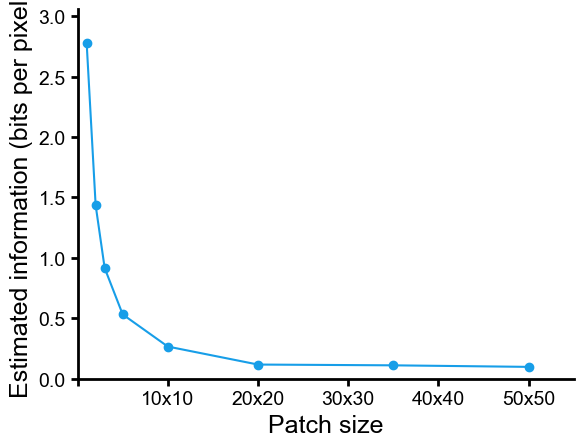

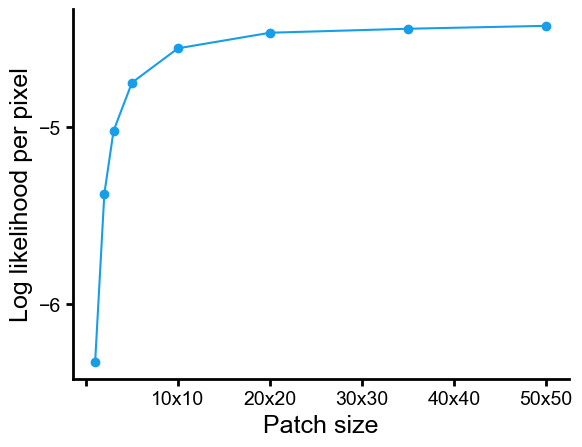

: 

In [14]:
from matplotlib.ticker import MaxNLocator

# Mutual information vs patch size
fig, ax = plt.subplots()
ax.plot(patch_sizes, [mi_estimates_gp[ps] for ps in patch_sizes], 'o-', label='GP')
ax.plot(patch_sizes, [mi_estimates_pixel_cnn[ps] for ps in patch_sizes], 'o-', label='PixelCNN')
clear_spines(ax)
ax.set(xlabel='Patch size', ylabel='Estimated information (bits per pixel)', ylim=[0, 1.1 * 
                        max(max(mi_estimates.values()), max(mi_estimates_pixel_cnn.values()))  ],
        xlim=[0, 1.1 * max(patch_sizes)], xticks=np.arange(0, 51, 10))
ax.set(xticklabels=[''] +[f'{ps}x{ps}' for ps in np.arange(10, 51, 10)])
ax.legend()

fig, ax = plt.subplots()
nll_per_pixel_gp = [test_set_NLL_gp[ps] for ps in patch_sizes]
nll_per_pixel_pixel_cnn = [test_set_NLL_pixel_cnn[ps] for ps in patch_sizes]

ax.plot(patch_sizes, nll_per_pixel_gp, 'o-', label='GP')
ax.plot(patch_sizes, nll_per_pixel_pixel_cnn, 'o-', label='PixelCNN')

clear_spines(ax)
ax.set(xlabel='Patch size', ylabel='Negative Log likelihood per pixel')
ax.set(xticklabels=[''] + [f'{ps}x{ps}' for ps in np.arange(10, 51, 10)], xticks=np.arange(0, 51, 10))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
